In [1]:
import yfinance
import numpy as np
import pandas as pd
import pandas
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import cufflinks as cf
cf.set_config_file(offline=True)

import warnings
warnings.filterwarnings("ignore")


In [2]:
from ActMng import AccountManager

In [3]:
starting_capital = 100000
allocation = 0.8

symbol = 'TSLA'

long_trend_days = 12
short_trend_days = 6

In [4]:
def fetch_data(symbol:str='SPY', start_date:str='2020', end_date:str=None):
    
    if end_date is None:
        end = pandas.Timestamp.now()
    else:
        end = end_date
    
    return pdr.get_data_yahoo(symbol, pandas.Timestamp(start_date), pandas.Timestamp(end))[['Open','Close']]
df = fetch_data(symbol)

[*********************100%***********************]  1 of 1 completed


In [5]:
fast_trend = df.Open.rolling(window=short_trend_days).mean()
slow_trend = df.Open.rolling(window=long_trend_days).mean()

df['ma_fast'] = fast_trend
df['ma_slow'] = slow_trend
df[['Close','ma_fast','ma_slow']].iplot()

In [6]:
df['trade_direction'] = np.sign(fast_trend-slow_trend)
df

,Open,Close,ma_fast,ma_slow,trade_direction
Date,,,,,
2019-12-31,81.000000,83.666000,NaN,NaN,NaN
2020-01-02,84.900002,86.052002,NaN,NaN,NaN
2020-01-03,88.099998,88.601997,NaN,NaN,NaN
2020-01-06,88.094002,90.307999,NaN,NaN,NaN
2020-01-07,92.279999,93.811996,NaN,NaN,NaN
...,...,...,...,...,...
2021-11-08,1149.790039,1162.939941,1182.315002,1096.203339,1.0
2021-11-09,1173.599976,1023.500000,1187.081665,1119.378337,1.0
2021-11-10,1010.409973,1067.949951,1162.256663,1124.368332,1.0


In [8]:
#Determine the direction of the moving average differences
df_trades = df['trade_direction'].dropna().diff().dropna().apply(np.sign).astype('int8')
df_trades = pandas.DataFrame(df_trades[df_trades !=0])

#Label our intended trades
df_trades['trade'] = df['trade_direction'].map({1:'Long',-1:'Short'})
df['trades'] = df_trades['trade']


In [9]:
#Label our opening trade after removing our window period
df['trades'].replace(pandas.np.NaN,'None',inplace=True)
df = df.dropna()
df['trades'].iloc[0]=('Long' if df['trade_direction'].iloc[0]==1.0 else 'Short')
df

,Open,Close,ma_fast,ma_slow,trade_direction,trades
Date,,,,,,
2020-01-16,98.750000,102.697998,101.338666,94.762166,1.0,Long
2020-01-17,101.522003,102.099998,101.689000,96.472333,1.0,None
2020-01-21,106.050003,109.440002,103.304334,98.234833,1.0,None
2020-01-22,114.377998,113.912003,105.917334,100.424667,1.0,None
2020-01-23,112.849998,114.440002,106.583668,102.487666,1.0,None
...,...,...,...,...,...,...
2021-11-08,1149.790039,1162.939941,1182.315002,1096.203339,1.0,None
2021-11-09,1173.599976,1023.500000,1187.081665,1119.378337,1.0,None
2021-11-10,1010.409973,1067.949951,1162.256663,1124.368332,1.0,None


In [10]:
# Our trading strategy implementation - feel free to brose ActMng.py if you are curious.
trading_strategy = AccountManager(symbol=symbol,trades_df=df,starting_capital=starting_capital,allocation_amount=allocation)
results = trading_strategy.run()

In [11]:
#Here we can see a day by day breakdown of the account
results['result_df']

,Open,Close,ma_fast,ma_slow,trade_direction,trades,account_val,cash_bal,position,position_changes,fees
2020-01-16,98.750000,102.697998,101.338666,94.762166,1.0,Long,103197.391658,19998.662500,810.13,810.13,1.0
2020-01-17,101.522003,102.099998,101.689000,96.472333,1.0,None,102712.934264,19998.662500,810.13,0.00,0.0
2020-01-21,106.050003,109.440002,103.304334,98.234833,1.0,None,108659.291678,19998.662500,810.13,0.00,0.0
2020-01-22,114.377998,113.912003,105.917334,100.424667,1.0,None,112282.193137,19998.662500,810.13,0.00,0.0
2020-01-23,112.849998,114.440002,106.583668,102.487666,1.0,None,112709.941678,19998.662500,810.13,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08,1149.790039,1162.939941,1182.315002,1096.203339,1.0,None,273819.366144,39626.520744,201.38,0.00,0.0
2021-11-09,1173.599976,1023.500000,1187.081665,1119.378337,1.0,None,245738.950744,39626.520744,201.38,0.00,0.0
2021-11-10,1010.409973,1067.949951,1162.256663,1124.368332,1.0,None,254690.281911,39626.520744,201.38,0.00,0.0
2021-11-11,1102.770020,1063.510010,1149.830007,1130.875005,1.0,None,253796.166510,39626.520744,201.38,0.00,0.0


In [12]:
# Here are our simulated orders as we would submit to an API endpoint for algorthmic trading. 
results['broker_orders']

,symbol,date,time,order,order_type,price,size,exchange_fees
2020-01-16,TSLA,2020-01-16 00:00:00,At Market Open,BUY,MARKET,98.750000,810.13,1.0
2020-02-28,TSLA,2020-02-28 00:00:00,At Market Open,SELL,MARKET,125.940002,810.13,1.0
2020-02-28,TSLA,2020-02-28 00:00:00,At Market Open,SELL,MARKET,125.940002,775.13,1.0
2020-03-27,TSLA,2020-03-27 00:00:00,At Market Open,BUY,MARKET,101.000000,775.13,1.0
2020-03-27,TSLA,2020-03-27 00:00:00,At Market Open,BUY,MARKET,101.000000,1119.64,1.0
...,...,...,...,...,...,...,...,...
2021-09-28,TSLA,2021-09-28 00:00:00,At Market Open,BUY,MARKET,787.200012,228.93,1.0
2021-09-28,TSLA,2021-09-28 00:00:00,At Market Open,BUY,MARKET,787.200012,201.38,1.0
2021-11-12,TSLA,2021-11-12 00:00:00,At Market Open,SELL,MARKET,1047.500000,201.38,1.0
2021-11-12,TSLA,2021-11-12 00:00:00,At Market Open,SELL,MARKET,1047.500000,191.37,1.0


absolute_return_tf: %153.0
CAGR_tf: %66.0
information_ratio_tf: %1.1117


<AxesSubplot:>

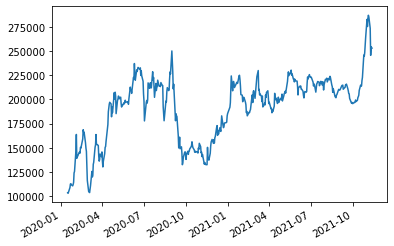

In [13]:
#Todo:
r_df = results['result_df']

# Calculate the Absolute Return of our trend-following trading strategy
absolute_return_tf = (r_df['account_val'].iloc[-1]-starting_capital)/starting_capital
print(f"absolute_return_tf: %{np.round(absolute_return_tf,2)*100}")

# Calculate the CAGR or our trend-following trading strategy
CAGR_tf = (r_df['account_val'].iloc[-1]/starting_capital)**(252/len(df))-1
print(f"CAGR_tf: %{np.round(CAGR_tf,2)*100}")

# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_tf = (r_df.account_val.pct_change().mean()/r_df.account_val.pct_change().std())*((252) **0.5)
print(f"information_ratio_tf: %{np.round(information_ratio_tf,4)}")

#Plot the equity curve (hint: use 'account_val')
r_df.account_val.plot()

In [14]:
#Todo:
# Calculate the Absolute Return of a buy-and-hold strategy in the same period
absolute_return_bh = (r_df.Close.iloc[-1]-r_df.Open.iloc[0])/r_df.Open.iloc[0]
print(f"absolute_return_bh: %{np.round(absolute_return_bh,2)}")

# Calculate the CAGR or our trend-following trading strategy
CAGR_bh = ((r_df.Close.iloc[-1]/ r_df.Open.iloc[0])**(252/len(df)))-1
print(f"CAGR_bh: % {np.round(CAGR_bh ,2)*100}")

# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_bh = (r_df.Close.pct_change().mean()/r_df.Close.pct_change().std())*((252) **0.5)
print(f"information_ratio_bh: % {np.round(information_ratio_bh,4)}")

#Plot the equity curve (hint: use 'close' returns and your initial capital value to generate an equity curve)
((r_df.Close.pct_change().dropna()+1).cumprod()*starting_capital).iplot()

absolute_return_bh: %9.47
CAGR_bh: % 260.0
information_ratio_bh: % 2.048


In [ ]:
#Todo - optional, below:
# Copy any of the code from above to new cells below, and see how changing the symbol, dates and trend parameters changes the performance
# Can you beat the reference implementation?